In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Set2')


## Read the data

In [10]:
df = pd.read_csv('../data/train_data.csv')
numerical_features = ['Weight', 'Height', 'Age', 'Meal_Count', 'Phys_Act', 'Water_Consump']
categorical_features = ['Smoking', 'Alcohol_Consump', 'Transport']
target = 'Body_Level'

df = df[numerical_features + categorical_features + [target]]


## Normalize the data

In [11]:
# encode categorical features
df = pd.get_dummies(df, columns=categorical_features)

# # normalize all features
# for feature in list(df.columns):
#     if feature == target:
#         continue
#     df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
# df.head()

## Prepare the data

In [12]:
X = df.drop('Body_Level', axis=1) # x contains all features except the target
# X = df.drop('Alcohol_Consump_Always', axis=1) 

# take the weight and height columns only
X = X[['Weight', 'Height']]
y = df['Body_Level'] # y contains only the target
y = y.map({'Body Level 1': 0, 'Body Level 2': 1, 'Body Level 3': 2, 'Body Level 4': 3}) # encode target to numerical values
formatter = plt.FuncFormatter(lambda val, loc: ['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4'][val]) # used to format the y axis ticks


## Train the model

In [13]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X, y)
cv_results = cross_validate(clf, X, y, cv=10, scoring=['f1_macro', 'accuracy', 'f1_micro'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


accuracy:  0.9822105113231732
f1_macro:  0.9753935475283063
f1_micro:  0.9822105113231732


## Visualize the model

### Feature Importance Plot
A feature importance plot shows the importance of each feature in the model. It can be used to identify the most important features and to understand the impact of each feature on the model's predictions.

Feature ranking:
1. feature 0 (0.792843) - Weight
2. feature 1 (0.207157) - Height


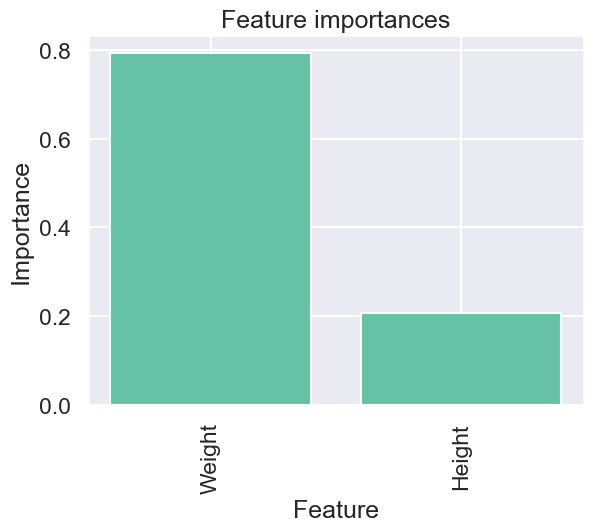

In [14]:
# Get the feature importances
importances = clf.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f) - %s" % (f + 1, indices[f], importances[indices[f]], X.columns[indices[f]]))


# Create a bar chart of the feature importances
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.show()


### Tree Plot
A tree plot shows the structure of the decision trees used in the random forest. It can be used to understand how the model makes predictions.

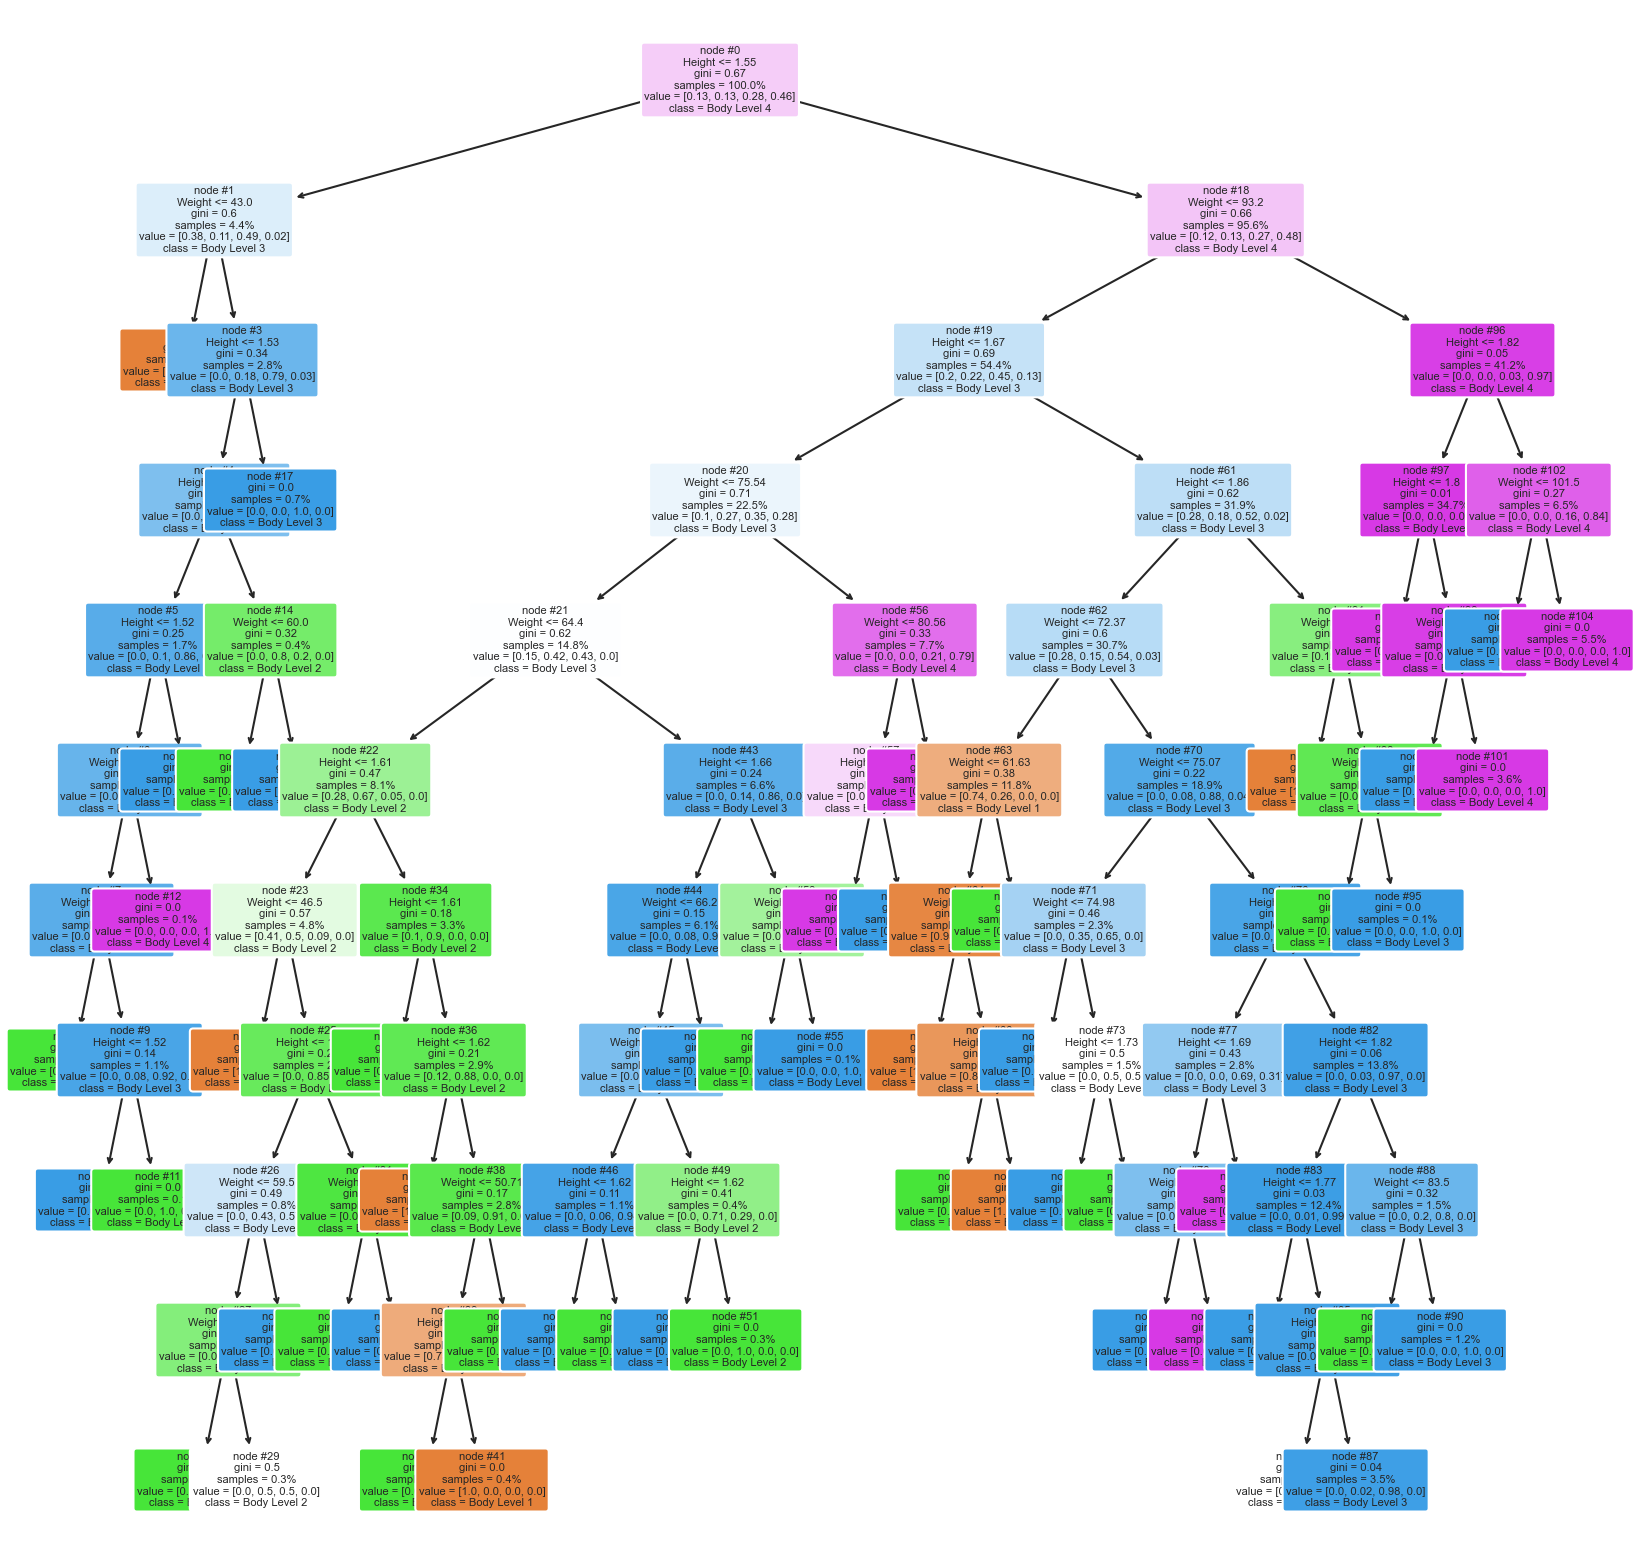

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# impurity=True shows the impurity measure at each node, 
# proportion=False does not show the proportion of samples in each class, 
# precision=2 sets the precision of the impurity measure to two decimal places, 
# node_ids=True shows the node IDs.
plt.figure(figsize=(20,20))
plot_tree(clf.estimators_[0], feature_names=X.columns, class_names=['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4'], 
            fontsize=8, impurity=True, rounded=True, proportion=True, precision=2, filled=True, node_ids=True)
plt.show()



### Partial Dependence Plot:
A partial dependence plot shows the relationship between a feature and the model's predictions while holding all other features constant. It can be used to understand the impact of a single feature on the model's predictions i.e. PDPs show the average effect on predictions as the value of feature changes.



From the plots, we may see the type of the relationship between a feature and a prediction. Some relationships may look linear whereas other are more complex.

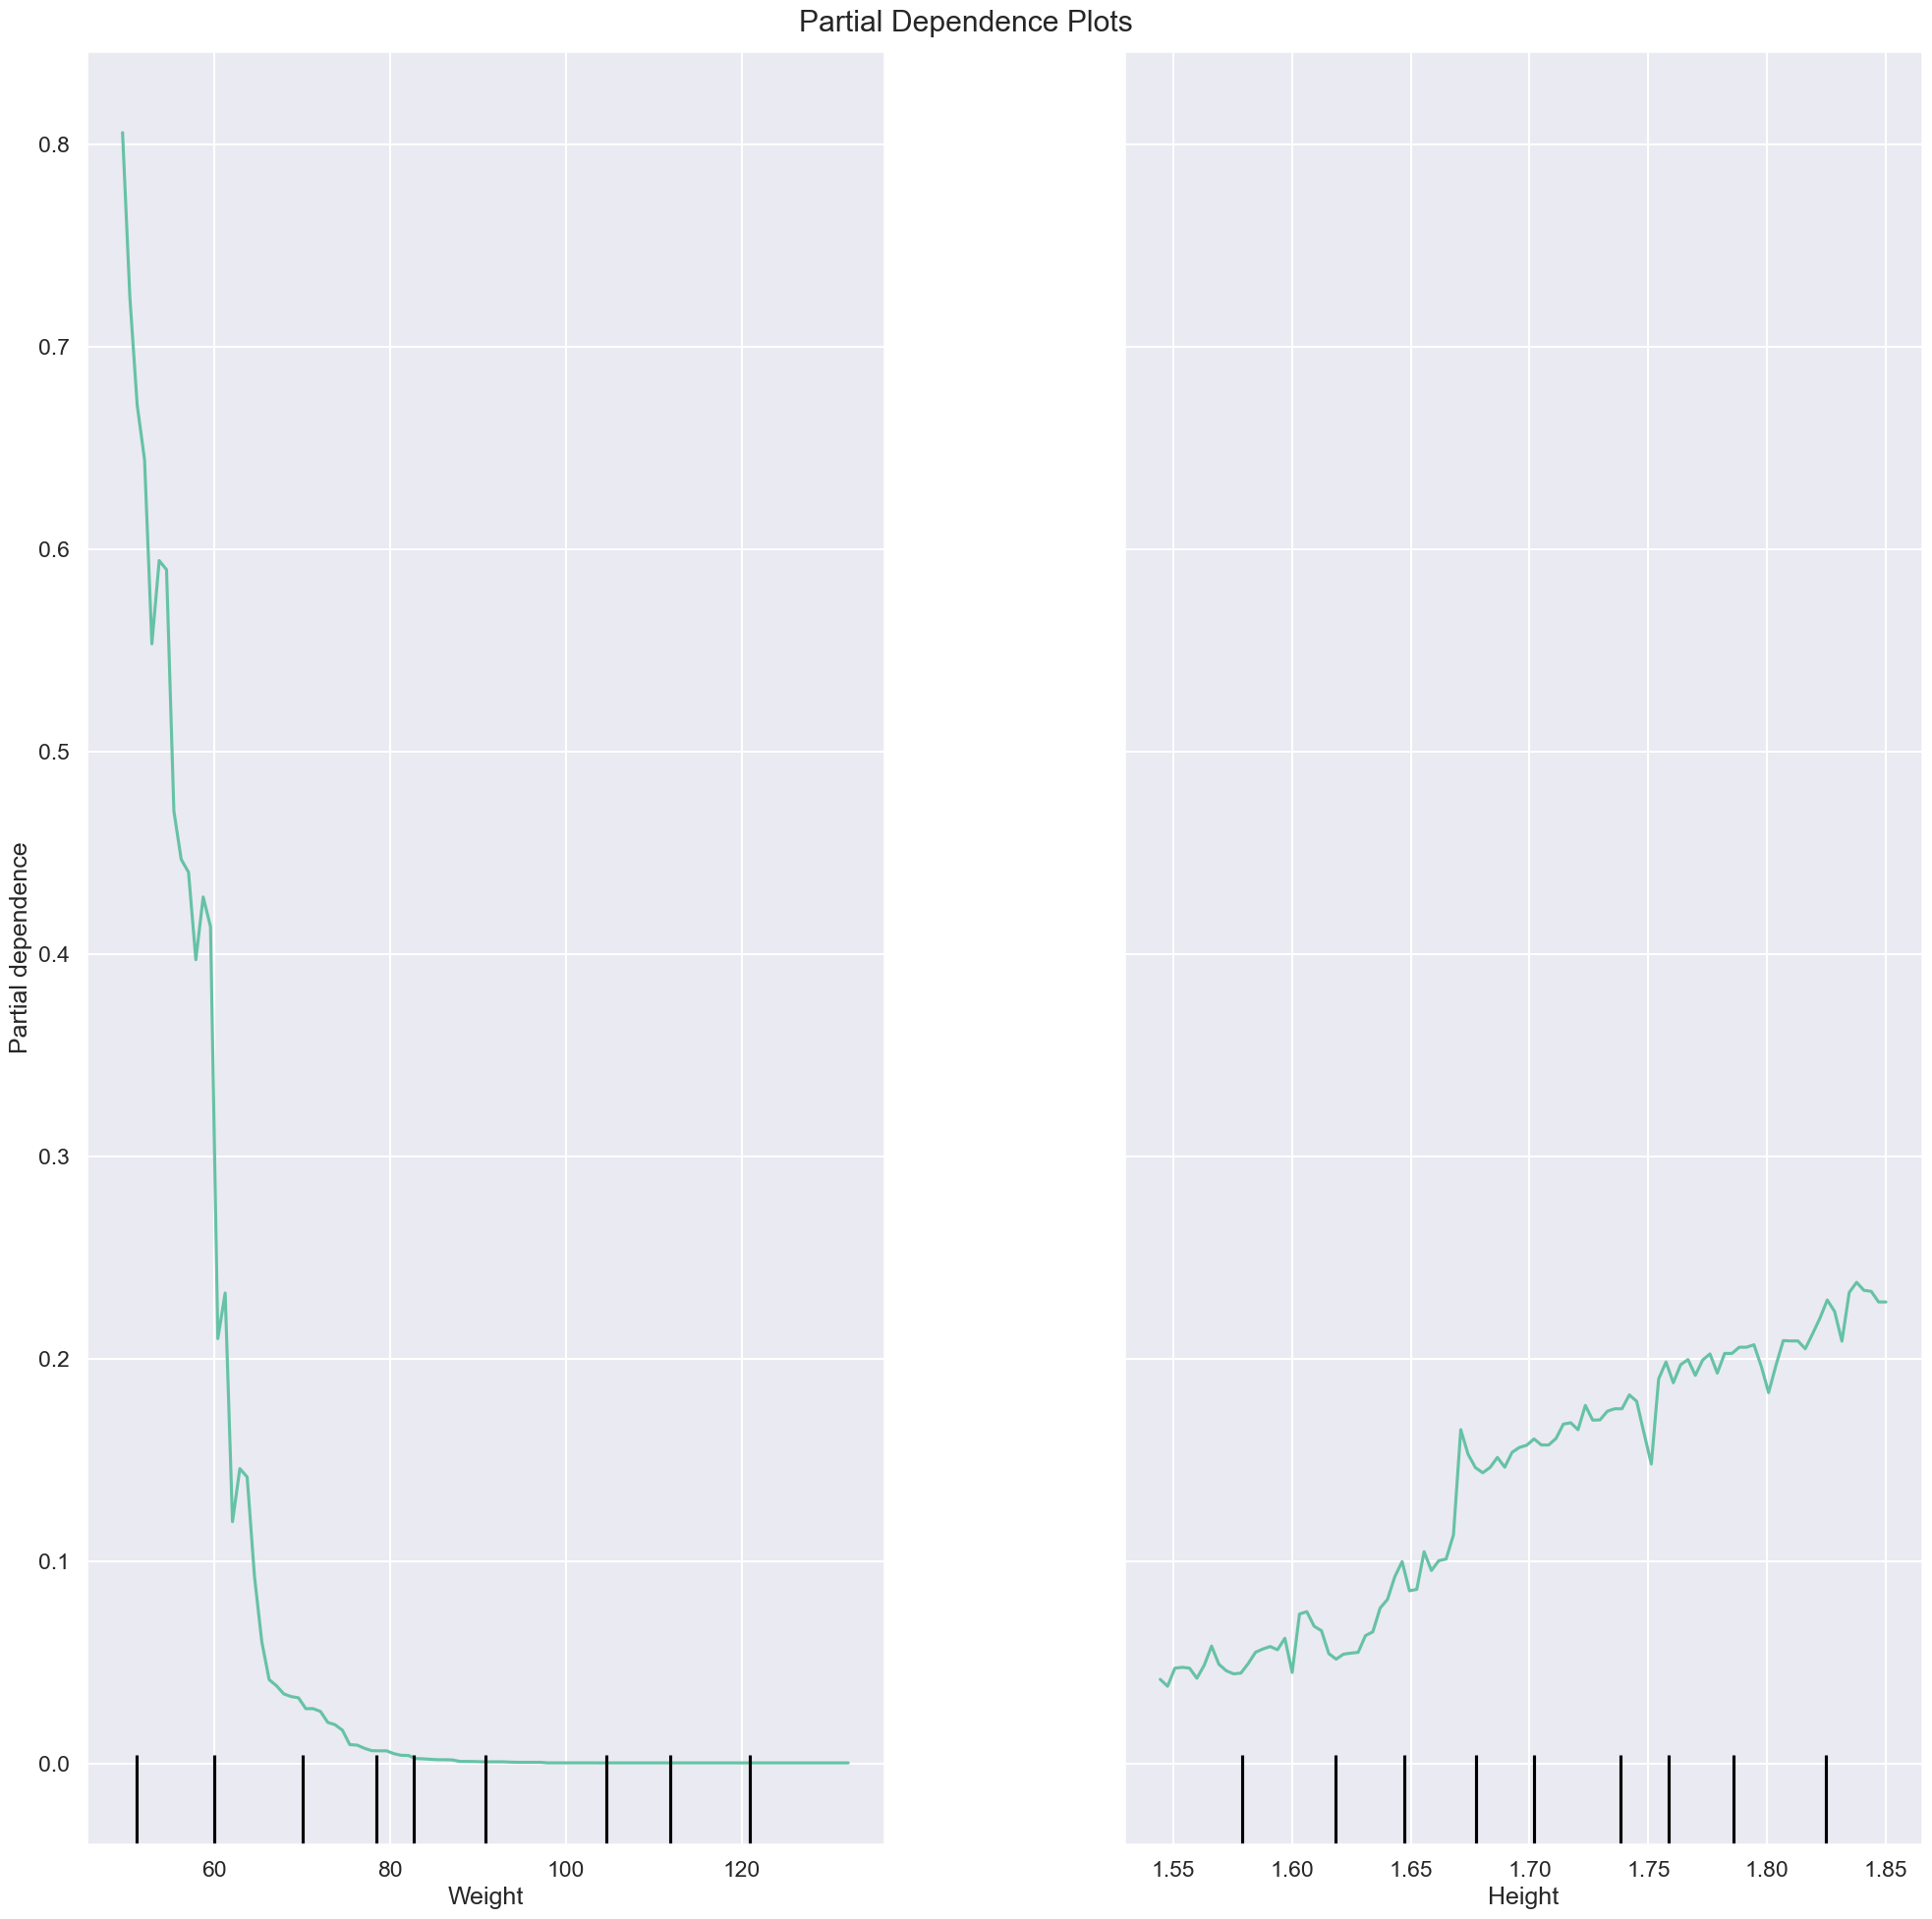

In [16]:
from sklearn.inspection import  PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(20, 20), )
target_class = 0  # specify the target class
PartialDependenceDisplay.from_estimator(clf, X, X.columns, ax=ax, target=target_class)

# Increase spacing between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)

fig.suptitle('Partial Dependence Plots')
fig.tight_layout();
